In [26]:
import pandas as pd
import json
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
from tqdm import tqdm
from pydantic import BaseModel

# Load the data
datas = pd.read_csv("./Data/gsm_data/gsm_train.tsv", sep="\t")


class Step(BaseModel):
    explanation: str
    output: str

class ListResponse(BaseModel):
    steps: list[Step]
    final_answer: list[str]

class FloatResponse(BaseModel):
    steps: list[Step]
    final_answer: float

class FlistResponse(BaseModel):
    steps: list[Step]
    final_answer: list[float]

class EasyResponse(BaseModel):
    final_answer: list[str]
    
client = OpenAI(
    base_url="https://api.chatanywhere.tech/v1"
)

def chat(says,outformat):
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": "You are an experienced optimization master."},
            {"role": "user", "content": says},
        ],
        response_format=outformat,
    )
    message = completion.choices[0].message
    if message.parsed:
        #print(message.parsed.steps)
        print(message.parsed.final_answer)
        return message.parsed.final_answer
    else:
        print(message.refusal)
        chat(says)
    
def Getvalue(ch,str):
    s = str.find(ch)
    e = str[s+1:].find(ch)
    return str[s+1:s+e+1]

meta_prompt = "Instruction that can improve the accuracy and effectiveness of LLMs typically leads models to gradually reason, analyze in detail, think structurally, and collaborate to solve problems. The generated instructions need to be as concise as possible."
ini_prompt = [{"instruction": "Let’s think step by step."},{"instruction": "Let’s think carefully about the problem and solve it together."},{"instruction":" Break this down"}]

def Obj(INS):
    s = 0
    #load WrongIndex.json
    with open('WrongIndex.json','r') as f:
        WrongIndex = json.load(f)
    
    # fast version
    # for i in range(len(WrongIndex)):
    #     quesion = datas.iloc[WrongIndex[i],0] + INS
    #     answer = chat(quesion,FloatResponse)
    #     if answer == datas.iloc[WrongIndex[i],1]:
    #         s += 1
    #         print("Correct")
    # return s/len(WrongIndex)
    
    for i in range(len(datas)):
        quesion = datas.iloc[i,0] + INS
        answer = chat(quesion,FloatResponse)
        if answer == datas.iloc[i,1]:
            s += 1
            print("Correct")
    return s/len(datas)
    
def warm_strat(num):
    pt = (
        "You need to generate {} instructions to enhance the performance of LLM."
        "This is a summary of experiences that may help you."
        "{}"
        "Common instructions for reference include:"
        "{}"
        "Please give your recommended instructions.").format(num,json.dumps(meta_prompt),meta_prompt)
    datas = chat(pt,ListResponse)
    return datas

def candidate_sampling(history,num):
    pt = (
        "Based on the previous optimization results {}, you need to provide {} candidate instruction for the next optimization."
        "This is a summary of experiences that may help you."
        "{}"
        "Please give your recommended instructions which need to be as concise as possible.").format(json.dumps(history),num,meta_prompt)
    datas = chat(pt,ListResponse)
    return datas

agent_prompts = {
    "optimistic": "You are an optimistic agent. Inclined to explore uncertainties.",
    "pessimistic": "You are a pessimistic agent. Inclined to avoid risks.",
    "Conservative": "You are a conservative agent. You weigh the pros and cons to make decisions.",
}
def AcquisitionFunction(history,pred):
    
    m = 2
    inipt = ("{}"
            "You need to reasonably select the most potential parameters from the predicted data table based on your own experience and historical data tables for the next optimization step."
            "We hope you can balance the relationship between exploration and exploitation to achieve the best results."
            "The following is a historical data table, with format [Instruction] - [acc]:"
            "{}"
            "The following is a predicted data table, with format [Instruction] - [predacc]:"
            "{}"
            "A brief summary of your reasons, as concise as possible."
            "Please provide 2 sets of parameter combinations that you consider optimal")
    res = {"optimistic":"","Conservative":"","pessimistic":""}
    datas = []
    for i in agent_prompts.keys():
            flag  = 1 #Determine whether the output meets the format.
            while flag:
                pt = inipt.format(agent_prompts[i],json.dumps(history),json.dumps(pred))
                res[i] = chat(pt)
                str = Getvalue("*",res[i])
                str = "[" + str + "]"
                try:
                    data =  ast.literal_eval(str)
                except Exception as e:
                    continue
                if len(data) == 2:
                    datas.append(data)
                    flag = 0
                
    pt = ("{}"
            "The parameter combination chosen by the three of you is: "
            "{}"
            "The reasons for the choices made by the other two are: "
            "{} and {}"
            "A brief summary of your reasons, as concise as possible."
            "Please select one best parameter combination from those chosen by everyone.")
    keys = list(agent_prompts.keys())
    for i in range(m):
        for index, key in enumerate(agent_prompts.keys()):
            flag  = 1 #Determine whether the output meets the format.
            while flag:
                pt = pt.format(agent_prompts[key],datas,res[keys[(index+1)%3]],res[keys[(index+2)%3]])
                print(pt)
                res[i] = chat(pt)
                str = Getvalue("*",res[i])
                str = "[" + str + "]"
                try:
                    data =  ast.literal_eval(str)
                except Exception as e:
                    continue
                if len(data) == 1:
                    flag = 0
    return data[0]

def SurrogateModel(history,samples):
    data_pred = []
    pt = ("You need to estimate the accuracy of this instruction on the gsm(A dataset of mathematical question and answer.) dataset."
        "This is a summary of experiences that may help you."
        "{}"
        "Below is the historical evaluation data"
        "{}"
        "Please guess the accuracy for these instructions as follow:"
        "{}").format(json.dumps(history),meta_prompt,samples)
    datas = chat(pt,FlistResponse)
    return datas

In [27]:
### config
numiters = 20        # number of iters for BO
numinipoint = 2      # number of ini points
numsamples = 2       # number of sampled points

arrloss = [0]
ins = warm_strat(2)
pairs = []
for i in range(numinipoint):
    s = Obj(ins[i])
    arrloss[0] = max(arrloss[0],s)
    pairs.append({"instruction": ins[i], "accuracy": s})

['Deconstruct tasks step-by-step and analyze each element in detail before proceeding.', 'Regularly evaluate your reasoning processes and refine your approach upon finding discrepancies.']
16.0
Correct
26.166666666666668
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0
168.0
16.0
Correct
26.166666666666668
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
32.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
15.0
2.0
Correct
2800.0
2125.0
148.0


In [30]:
for i in tqdm(range(numiters)):
    ins_sp = candidate_sampling(pairs,numsamples)
    s = SurrogateModel(pairs,ins_sp)
    index = s.index(max(s))
    pairs.append({"instruction": ins_sp[index], "accuracy": Obj(ins_sp[index])})

  0%|          | 0/20 [00:00<?, ?it/s]

['"Apply detailed, step-by-step reasoning for each task stage."', '"Break tasks into logical steps for detailed analysis."']
[0.45, 0.4]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
32.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


  5%|▌         | 1/20 [01:32<29:23, 92.79s/it]

168.0
['Break tasks into logical steps and analyze each thoroughly.', 'Apply logical reasoning incrementally at each stage for clarity.']
[0.45, 0.4]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 10%|█         | 2/20 [03:10<28:38, 95.45s/it]

168.0
['Systematically deconstruct tasks into small, logical steps with precise analysis.', 'Apply detailed step-by-step logical reasoning to each task element for clarity.']
[0.45, 0.5]
16.0
Correct
26.166666666666668
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
96.0
Correct
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
24.0
2.0
Correct
2800.0
2125.0


 15%|█▌        | 3/20 [04:52<27:59, 98.80s/it]

168.0
['Divide problems into manageable parts for detailed step-by-step analysis.', 'Utilize logical sequences for thorough and precise solution analysis.']
[0.45, 0.4]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
15.0
2.0
Correct
1000.0
Correct
2125.0


 20%|██        | 4/20 [07:21<31:35, 118.49s/it]

44.0
['Systematically break complex problems into smaller, logical steps for detailed analysis.', 'Gradually apply detailed, logical reasoning to each task for precision.']
[0.45, 0.4]
16.0
Correct
36.833333333333336
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
96.0
Correct
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
2800.0
2125.0


 25%|██▌       | 5/20 [08:45<26:31, 106.11s/it]

220.0
Correct
['Break tasks into logical steps and analyze each in detail.', 'Use gradual, detailed reasoning to analyze each task segment.']
[0.475, 0.45]
16.0
Correct
26.1667
85.0
0.0
574.0
13.0
Correct
8.0
19200.0
70.0
Correct
32.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
27.0
Correct
2.0
Correct
2800.0
2125.0


 30%|███       | 6/20 [10:29<24:35, 105.38s/it]

172.0
['"Develop structured, logical steps for detailed task analysis, ensuring accuracy."', '"Break down tasks methodically, using logic and detail for clear solutions."']
[0.45, 0.45]
16.0
Correct
26.167
85.0
0.0
574.0
11.0
8.0
19200.0
46.0
96.0
Correct
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 35%|███▌      | 7/20 [12:00<21:46, 100.53s/it]

168.0
['Utilize detailed, step-by-step reasoning for precise problem analysis.', 'Break down tasks into logical steps, analyzing each part meticulously.']
[0.4, 0.4]
16.0
Correct
26.1667
85.0
0.0
574.0
11.0
8.0
19200.0
48.0
32.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 40%|████      | 8/20 [13:38<19:57, 99.78s/it] 

172.0
['Systematically break down problems into logical, detailed steps for accurate solutions.', 'Collaborate and apply gradual, detailed reasoning for deeper problem understanding.']
[0.45, 0.35]
16.0
Correct
26.1666667
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
6.0
2.0
Correct
1000.0
Correct
2125.0


 45%|████▌     | 9/20 [15:09<17:46, 96.94s/it]

220.0
Correct
['"Break tasks into systematic, logical steps for detailed analysis."', '"Use clear, step-by-step logic for detailed problem analysis."']
[0.4, 0.45]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1800.0
2125.0


 50%|█████     | 10/20 [16:32<15:26, 92.64s/it]

2.0
['"Systematically break down tasks into logical, detailed steps."', '"Use incremental, detailed reasoning for each task element."']
[0.45, 0.4]
16.0
Correct
26.0
85.0
0.0
574.0
11.0
8.0
19200.0
58.0
64.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
15.0
2.0
Correct
1000.0
Correct
2125.0


 55%|█████▌    | 11/20 [18:01<13:45, 91.73s/it]

240.0
['"Emphasize gradual, logical reasoning and thorough analysis in concise steps."', '"Develop structured, logical steps for thorough, collaborative analysis."']
[0.45, 0.35]
16.0
Correct
26.1667
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
32.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
2800.0
2125.0


 60%|██████    | 12/20 [19:27<11:59, 89.88s/it]

0.0
['Break problems into logical steps and analyze thoroughly for clarity.', 'Use detailed, step-by-step reasoning to enhance precision.']
[0.4, 0.45]
16.0
Correct
26.166666666666668
85.0
31.0
574.0
11.0
8.0
19200.0
70.0
Correct
32.0
24.0
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 65%|██████▌   | 13/20 [20:54<10:22, 88.91s/it]

172.0
['"Assert logical reasoning at each stage with concise detail for clarity."', '"Use clear, logical steps to analyze tasks for precise solutions."']
[0.35, 0.4]
16.0
Correct
26.166666666666668
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
96.0
Correct
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 70%|███████   | 14/20 [22:16<08:42, 87.09s/it]

172.0
['1. Structure tasks into detailed, logical steps for improved accuracy.', '2. Apply systematic, step-by-step reasoning for precise solutions.']
[0.4, 0.45]
16.0
Correct
26.0
85.0
0.0
574.0
13.0
Correct
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
15.0
2.0
Correct
1000.0
Correct
2125.0


 75%|███████▌  | 15/20 [23:43<07:14, 86.93s/it]

129.0
['Systematically deconstruct problems into logical, detailed steps for thorough analysis.', 'Apply step-by-step logical reasoning and detailed analysis for precise solutions.']
[0.4, 0.45]
16.0
Correct
26.1667
85.0
0.0
574.0
13.0
Correct
8.0
19200.0
70.0
Correct
96.0
Correct
24.0
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 80%|████████  | 16/20 [25:11<05:49, 87.31s/it]

220.0
Correct
['"Break tasks into structured, logical parts and analyze each thoroughly."', '"Apply methodical, step-by-step reasoning for thorough analysis."']
[0.45, 0.45]
16.0
Correct
26.1667
85.0
0.0
574.0
11.0
8.0
19200.0
46.0
64.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
15.0
2.0
Correct
1000.0
Correct
2125.0


 85%|████████▌ | 17/20 [27:42<05:19, 106.34s/it]

-1.0
['"Structure tasks into detailed, logical steps for comprehensive analysis."', '"Apply detailed, step-by-step logical reasoning for clear solutions."']
[0.35, 0.4]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
46.0
32.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 90%|█████████ | 18/20 [29:18<03:26, 103.19s/it]

40.0
['"Analyze tasks through structured, logical steps for precise solutions."', '"Divide tasks into smaller, logical parts for detailed analysis."']
[0.4, 0.4]
16.0
Correct
26.166666666666668
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
32.0
18.0
Correct
3.5
80.0
15.0
Correct
52.0
Correct
27.0
Correct
2.0
Correct
1000.0
Correct
2125.0


 95%|█████████▌| 19/20 [30:39<01:36, 96.62s/it] 

220.0
Correct
['"Break tasks into logical, detailed steps for thorough analysis."', '"Use step-by-step logical reasoning for detailed, accurate analysis."']
[0.4, 0.45]
16.0
Correct
34.0
Correct
85.0
0.0
574.0
11.0
8.0
19200.0
70.0
Correct
64.0
18.0
Correct
3.5
80.0
375.0
52.0
Correct
15.0
2.0
Correct
1000.0
Correct
2125.0


100%|██████████| 20/20 [32:02<00:00, 96.13s/it]

168.0


In [31]:
for i in range(len(pairs)):
    print(pairs[i])

{'instruction': 'Deconstruct tasks step-by-step and analyze each element in detail before proceeding.', 'accuracy': 0.4}
{'instruction': 'Regularly evaluate your reasoning processes and refine your approach upon finding discrepancies.', 'accuracy': 0.25}
{'instruction': 'Collaborate with step-by-step reasoning to solve problems.', 'accuracy': 0.3}
{'instruction': 'Implement structured breakdown of tasks for detailed analysis.', 'accuracy': 0.3}
{'instruction': 'Incorporate gradual, detailed logical reasoning at every stage for heightened accuracy.', 'accuracy': 0.45}
{'instruction': '1. Divide tasks into smaller parts and apply gradual analysis for improved accuracy.', 'accuracy': 0.35}
{'instruction': 'Implement stepwise analysis and logical structuring for accuracy.', 'accuracy': 0.35}
{'instruction': 'Use clear, logical steps and detailed analysis to approach problems.', 'accuracy': 0.35}
{'instruction': 'Emphasize stepwise, logical reasoning for clearer problem-solving.', 'accuracy

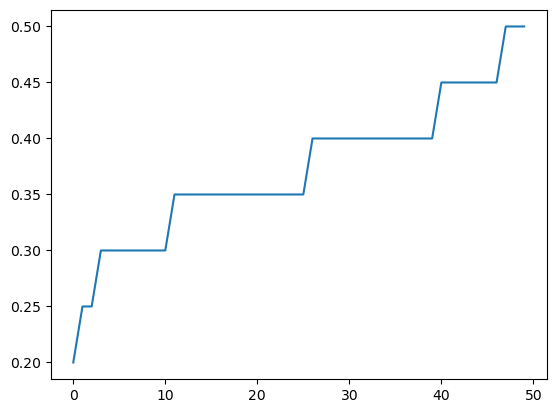

In [32]:
accuracy = []
for i in range(len(pairs)):
    accuracy.append(pairs[i]["accuracy"])
accuracy = np.array(accuracy)
plt.plot(accuracy)
plt.show()

In [34]:
#save pairs
with open('pairs.json','r') as f:
    ds = json.load(f)
ds.append(pairs)
with open('pairs.json','w') as f:
    json.dump(ds,f)

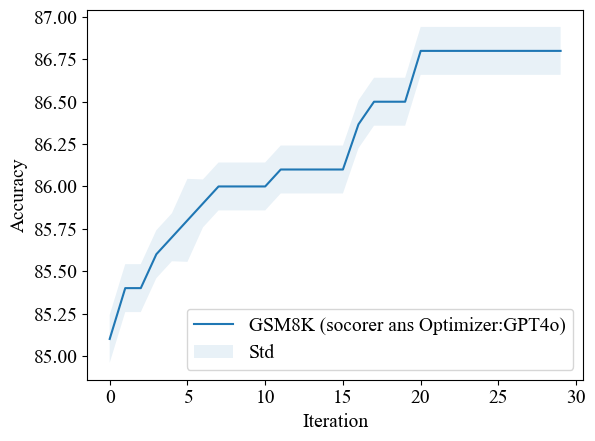

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
with open('pairs.json','r') as f:
    ds = json.load(f)
mean = []
std  = []

for i in range(len(ds[0])):
    mean.append(np.mean([trans(float(ds[j][i]["accuracy"])) for j in range(len(ds))]))
    std.append(np.std([trans(float(ds[j][i]["accuracy"])) for j in range(len(ds))]))

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 14})
plt.plot(mean)
plt.fill_between(len(ds[0]),np.array(mean)-np.array(std),np.array(mean)+np.array(std),alpha=0.1)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(['GSM8K (socorer ans Optimizer:GPT4o)','Std'],loc='lower right')
plt.savefig('GSM8K.pdf')
plt.show()
